### hw2:
> in the game Elona, it is fun to choose the various races and class, but one must choose wisely because it decides the difficulty level of the starting stage in this game. so, having the data of races and classes,  I want to ask some questions to help deciding them.

data: [info.json](./info.json) I create manually from [Elona Fandom](https://elona.fandom.com/wiki/Races)  
+ the json file tells the attribute bonus given by each race and class  

In [203]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [204]:
# the dict map ordinal data to integer
levelMap = {
    "Slight":1, "Little":2, "Normal":3, "Not bad":4, "Good":5, "Great":6, "Best":7
}

In [205]:
file = "./info.json"
with open(file) as f:
    data = json.load(f)
    
    # print out the json file
    print(json.dumps(data, indent=4))

{
    "race": {
        "Yerles": {
            "attribute": {
                "Str": "Normal",
                "Con": "Not bad",
                "Dex": "Not bad",
                "Per": "Not bad",
                "Lea": "Great",
                "Wil": "Not bad",
                "Mag": "Not bad",
                "Cha": "Normal",
                "Life": 110,
                "Mana": 90,
                "Spd": 70
            },
            "startingSkills": [
                "Martial Arts",
                "Firearms",
                "Throwing",
                "Literacy",
                "Negotiation"
            ]
        },
        "Eulderna": {
            "attribute": {
                "Str": "Normal",
                "Con": "Normal",
                "Dex": "Normal",
                "Per": "Good",
                "Lea": "Not bad",
                "Wil": "Good",
                "Mag": "Great",
                "Cha": "Not bad",
                "Life": 100,
                "Mana": 100,


--- 
#### Q1. which race gives the best average attribute bonus? (excluding Life, Mana, Spd)

In [206]:
# first, maps the attribute in every race from string(Normal, Not bad...) to integer
# by levelMap

# for race in data["race"].keys():
#     for attr in data["race"][race]["attribute"].keys():
#         if data["race"][race]["attribute"][attr] in levelMap.keys():
#             data["race"][race]["attribute"][attr] = levelMap[data["race"][race]["attribute"][attr]]

# this is equel to the above one
updateAttr = lambda attr, val: levelMap[val] if val in levelMap else val
for race in data["race"]:
    data["race"][race]["attribute"] = {attr: updateAttr(attr, val) 
                                       for attr, val in data["race"][race]["attribute"].items()}


In [207]:
# check the data mapping
# print(json.dumps(data, indent=4))

In [208]:
attrs = ["Str", "Con", "Dex", "Per", "Lea", "Wil", "Mag", "Cha"]
races = list(data["race"].keys())

# extract each attribute bonus values of each races 
raceAttr = [[data["race"][race]["attribute"][attr] for attr in attrs] for race in races]

# convert to dataframe and add columns, index
raceData = pd.DataFrame(raceAttr).T
raceData.columns = races
raceData.index = attrs
raceData

,Yerles,Eulderna,Fairy,Dwarf,Juere,Elea,Snail,Lich,Goblin,Golem,Mutant
Str,3,3,1,5,3,3,2,2,4,5,4
Con,4,3,2,5,4,3,2,4,4,7,2
Dex,4,3,4,4,6,4,1,3,2,2,2
Per,4,5,5,3,5,4,3,5,2,2,3
Lea,6,4,4,3,5,4,1,5,4,2,3
Wil,4,5,4,3,4,6,2,6,3,4,4
Mag,4,6,6,3,4,6,1,7,3,3,3
Cha,3,4,6,3,5,5,3,2,2,1,1


mean attribute of races: 
Juere       4.500
Elea        4.375
Lich        4.250
Eulderna    4.125
Yerles      4.000
Fairy       4.000
Dwarf       3.625
Golem       3.250
Goblin      3.000
Mutant      2.750
Snail       1.875
dtype: float64


Text(0.5, 1.0, 'attr distribution ordered by mean attr of races(high to low)')

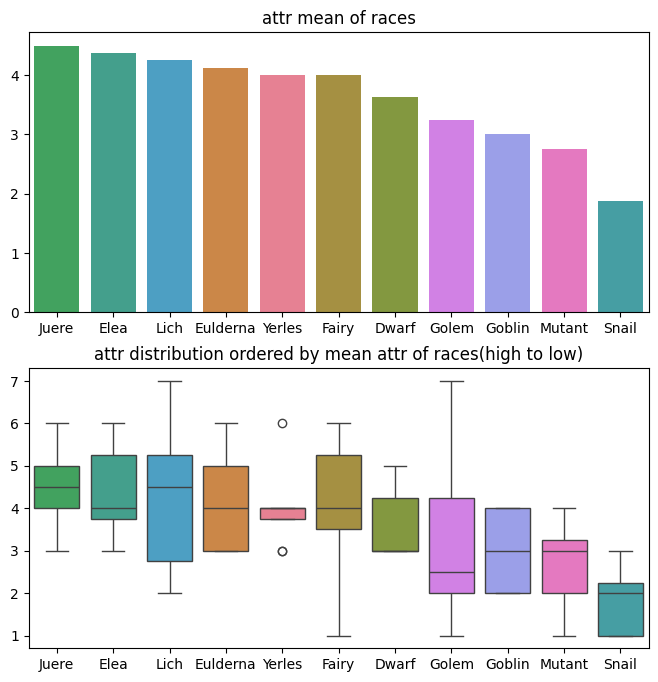

In [209]:
# use barplot and boxplot to visualize the mean attribute of races and each distribution

# get the order of raceData's mean
myOrder = raceData.mean().sort_values(ascending=False).index.tolist()
print("mean attribute of races: ")
print(raceData.mean().sort_values(ascending=False))

raceDataMean = pd.DataFrame(raceData.mean()).T

fig, axes = plt.subplots(2, 1, figsize=(8,8))

sns.barplot(ax=axes[0], data=raceDataMean, order=myOrder)
axes[0].set_title("attr mean of races")

sns.boxplot(ax=axes[1], data=raceData, order=myOrder)
axes[1].set_title("attr distribution ordered by mean attr of races(high to low)")

also i want to draw the radar chart to help verify it
+ ref: [Data Visualization: Radar chart](https://orcahmlee.github.io/data-science/radar-chart/)

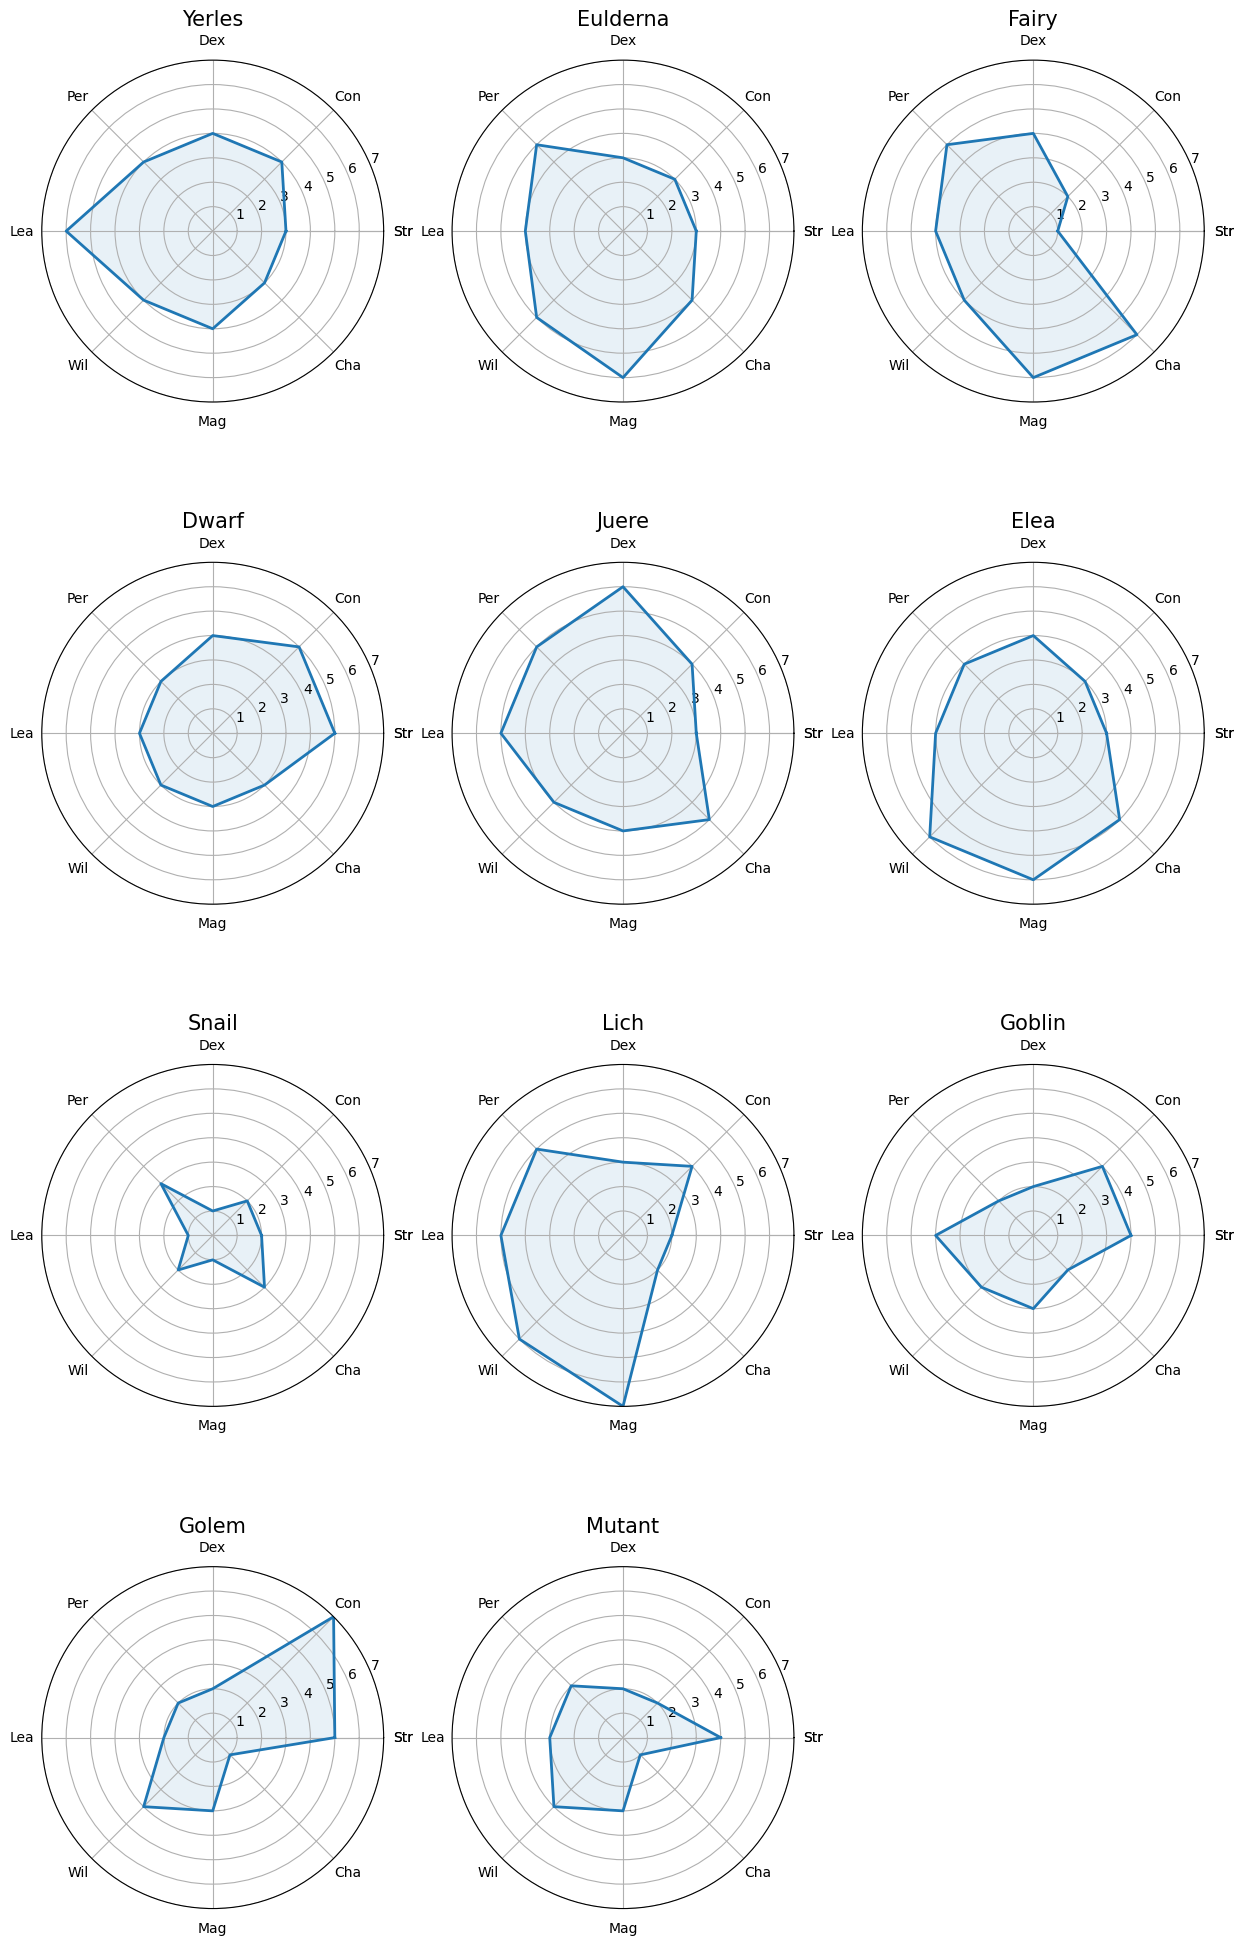

In [210]:
import math

# set up label and angle
labels = np.array(attrs)
angles = np.linspace(0, 2 * np.pi, len(attrs), endpoint=False)

attrLabel = np.concatenate((labels, [labels[0]]))
angles = np.concatenate((angles, [angles[0]]))

# set plot with 3 cols
fig, axs = plt.subplots(math.ceil(len(races)/3), 3, figsize=(15,25), subplot_kw=dict(polar=True))
axs = axs.flatten()

for i, race in enumerate(races):
    attOne = np.array(raceData[race])

    vals = np.concatenate((attOne, [attOne[0]]))

    ax = axs[i]
    ax.plot(angles, vals, '-', linewidth=2)
    ax.set_ylim(top=7)
    ax.set_thetagrids(angles*180 / np.pi, attrLabel)
    ax.fill(angles, vals, alpha=0.1)
    ax.set_title(race, fontsize=15)

fig.delaxes(axs[-1])
plt.show()

-> conclusion:  
for the average attribute bonus, Juere, Elea, Lich are the best 3.  
however from the boxblot, it should be noticed that Lich has some extreme bonus value(Mag being high, Str and Cha being low)

--- 
#### Q2. I want to be pianist, what is the best race for me?

assuming that a class gives bonus to an attribute because the attribute is important, I treat each attribute bonus as weight and let  
```
attr of race R = (attr of R * attr of class C),  for all attr in attr of C
```
then calculate the mean and plot bar and box

In [211]:
# maps the attribute value bonus of classes from ordinal(Normal, Not bad...) to integer
updateAttr = lambda attr, val: levelMap[val] if val in levelMap else val
for cla in data["class"]:
    data["class"][cla]["attribute"] = {attr: updateAttr(attr, val) 
                                       for attr, val in data["class"][cla]["attribute"].items()}

In [212]:
# check data
# d = data["class"]
# print(json.dumps(d, indent=4))

In [213]:
wantClass = "Pianist"

# get the bonus attribute of wantClass
expectAttr = data["class"][wantClass]["attribute"]
print(wantClass, "has bonus on: ", expectAttr)

pAttr = [[data["race"][race]["attribute"][attr]*expectAttr[attr] for attr in expectAttr.keys()] 
         for race in races]

pAttr = pd.DataFrame(pAttr).T
pAttr.columns = races
pAttr.index = list(expectAttr.keys())
pAttr

Pianist has bonus on:  {'Str': 3, 'Dex': 1, 'Per': 2, 'Lea': 2, 'Mag': 1, 'Cha': 4}


,Yerles,Eulderna,Fairy,Dwarf,Juere,Elea,Snail,Lich,Goblin,Golem,Mutant
Str,9,9,3,15,9,9,6,6,12,15,12
Dex,4,3,4,4,6,4,1,3,2,2,2
Per,8,10,10,6,10,8,6,10,4,4,6
Lea,12,8,8,6,10,8,2,10,8,4,6
Mag,4,6,6,3,4,6,1,7,3,3,3
Cha,12,16,24,12,20,20,12,8,8,4,4


mean attribute of races for Pianist : 
Juere       9.833333
Fairy       9.166667
Elea        9.166667
Eulderna    8.666667
Yerles      8.166667
Dwarf       7.666667
Lich        7.333333
Goblin      6.166667
Mutant      5.500000
Golem       5.333333
Snail       4.666667
dtype: float64


Text(0.5, 1.0, 'attr distribution ordered by mean attr of races(high to low)')

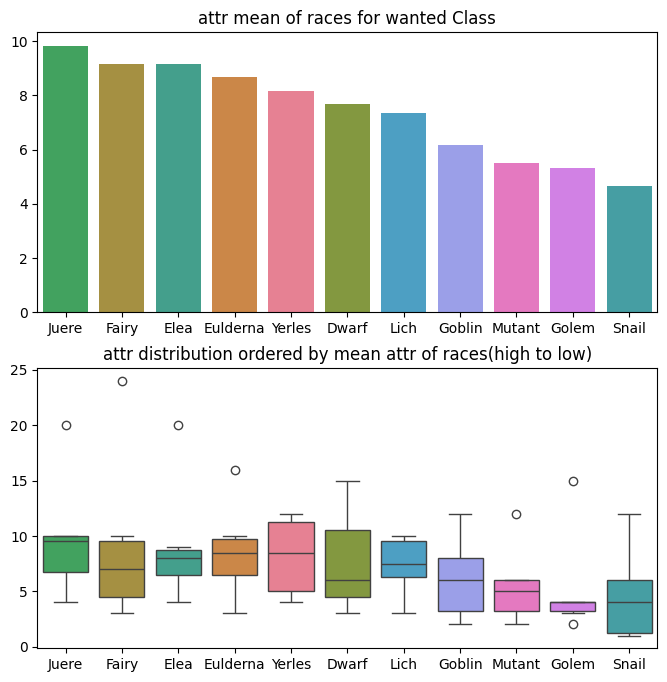

In [214]:
myOrder = pAttr.mean().sort_values(ascending=False).index.tolist()
print("mean attribute of races for", wantClass, ": ")
print(pAttr.mean().sort_values(ascending=False))

pAttrMean = pd.DataFrame(pAttr.mean()).T

fig, axes = plt.subplots(2, 1, figsize=(8,8))

sns.barplot(ax=axes[0], data=pAttrMean, order=myOrder)
axes[0].set_title("attr mean of races for wanted Class")

sns.boxplot(ax=axes[1], data=pAttr, order=myOrder)
axes[1].set_title("attr distribution ordered by mean attr of races(high to low)")

-> conclusion:  
Juere is a good choice

--- 
#### Q3. find the tier list(top 10) of <bold>race + class</bold> combination

extend Q2, calculate the mean for every combination of races and classes

In [215]:
comAttr = pd.DataFrame()
for cla in classes:
    expectAttr = data["class"][cla]["attribute"]
    tAttr = [[data["race"][race]["attribute"][attr]*expectAttr[attr] for attr in expectAttr.keys()] 
             for race in races]
    
    tAttr = pd.DataFrame(tAttr).T
    tAttr = pd.DataFrame(tAttr.mean()).T

    if(comAttr.empty):
        comAttr = tAttr
    else:
        comAttr = pd.concat([comAttr, tAttr], axis=0, ignore_index=True).reset_index(drop=True)

# eliminate NaN for class doesn't give any attribute bonus
comAttr.fillna(0, inplace=True)
comAttr.columns = races
comAttr.index = classes
comAttr

,Yerles,Eulderna,Fairy,Dwarf,Juere,Elea,Snail,Lich,Goblin,Golem,Mutant
Warrior,10.750000,9.500000,5.750000,14.250000,11.250000,10.000000,5.750000,9.750000,11.250000,16.500000,9.0
Thief,10.000000,8.400000,8.000000,9.600000,11.600000,8.800000,4.000000,8.800000,7.200000,8.000000,6.4
Wizard,12.500000,16.000000,15.000000,9.000000,12.750000,16.500000,5.000000,18.500000,8.750000,9.250000,10.0
Farmer,10.000000,8.200000,6.800000,8.400000,9.600000,8.800000,3.400000,9.400000,8.000000,8.400000,6.8
Archer,9.400000,8.200000,7.400000,10.000000,11.200000,8.600000,4.200000,8.200000,7.200000,8.600000,6.6
Warmage,9.000000,9.800000,7.800000,9.800000,9.400000,10.400000,4.000000,10.800000,8.200000,11.000000,7.4
Tourist,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Pianist,8.166667,8.666667,9.166667,7.666667,9.833333,9.166667,4.666667,7.333333,6.166667,5.333333,5.5
Priest,7.428571,8.857143,8.000000,6.142857,7.714286,9.571429,3.428571,9.857143,5.714286,6.571429,6.0
Claymore,9.600000,10.200000,9.000000,10.400000,11.400000,10.200000,4.800000,10.000000,7.600000,9.000000,7.8


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '(Wizard, Lich)'),
  Text(1, 0, '(Warrior, Golem)'),
  Text(2, 0, '(Wizard, Elea)'),
  Text(3, 0, '(Wizard, Eulderna)'),
  Text(4, 0, '(Wizard, Fairy)'),
  Text(5, 0, '(Warrior, Dwarf)'),
  Text(6, 0, '(Wizard, Juere)'),
  Text(7, 0, '(Wizard, Yerles)'),
  Text(8, 0, '(Thief, Juere)'),
  Text(9, 0, '(Claymore, Juere)')])

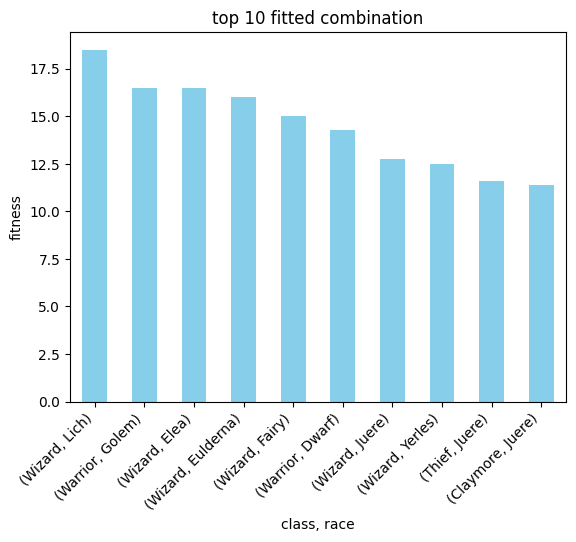

In [216]:
# sort and extract the top 10
stackedAttr = comAttr.stack().sort_values(ascending=False)
topAttr = stackedAttr.head(10)

topAttr.plot(kind='bar', color="skyblue")
plt.title('top 10 fitted combination')
plt.xlabel('class, race')
plt.ylabel('fitness')
plt.xticks(rotation=45, ha='right')

-> conclusion:  
as the plot above, choosing those combination of race and class will receive the most attribute bonus that matches the race and class's feature and thus being easy to play with

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, '(Tourist, Mutant)'),
  Text(1, 0, '(Tourist, Elea)'),
  Text(2, 0, '(Tourist, Yerles)'),
  Text(3, 0, '(Tourist, Snail)'),
  Text(4, 0, '(Tourist, Lich)'),
  Text(5, 0, '(Tourist, Goblin)'),
  Text(6, 0, '(Tourist, Golem)'),
  Text(7, 0, '(Tourist, Juere)'),
  Text(8, 0, '(Tourist, Eulderna)'),
  Text(9, 0, '(Tourist, Dwarf)'),
  Text(10, 0, '(Tourist, Fairy)'),
  Text(11, 0, '(Farmer, Snail)'),
  Text(12, 0, '(Priest, Snail)'),
  Text(13, 0, '(Warmage, Snail)'),
  Text(14, 0, '(Thief, Snail)'),
  Text(15, 0, '(Archer, Snail)'),
  Text(16, 0, '(Pianist, Snail)'),
  Text(17, 0, '(Claymore, Snail)'),
  Text(18, 0, '(Wizard, Snail)'),
  Text(19, 0, '(Pianist, Golem)')])

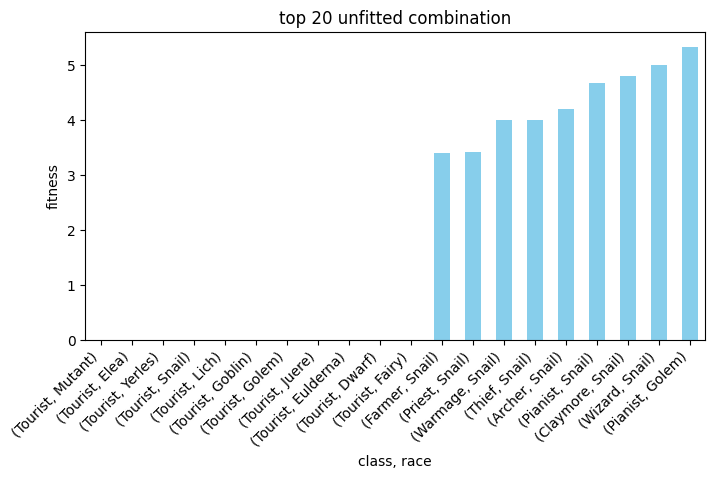

In [220]:
# just for fun, print the worst combinations

# sort and extract the worst 20
stackedAttr = comAttr.stack().sort_values(ascending=True)
topAttr = stackedAttr.head(20)

topAttr.plot(kind='bar', color="skyblue", figsize=(8,4))
plt.title('top 20 unfitted combination')
plt.xlabel('class, race')
plt.ylabel('fitness')
plt.xticks(rotation=45, ha='right')